In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
# sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/tweet_csv/trad/220131_trad.csv"
df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.drop("author_id", axis=1)
df = df.drop("username", axis=1)
# df = df.drop("tweet_id", axis=1)
df = df.drop("like_count", axis=1)
df = df.drop("retweet_count", axis=1)
df

,created_at,text
0,2022-01-31 15:00:15,始まったー♪ #稲垣吾郎 #吉田明世 #tokyofm #THETRAD
1,2022-01-31 15:00:26,もう、こんな時間！ 待機～📻️ #THETRAD #稲垣吾郎 #吉田明世
2,2022-01-31 15:00:30,#THETRAD
3,2022-01-31 15:00:35,ダレハナとクロストーク 吾郎店長はスカイダイビング🪂は無理。バンジージャンプとかも。髪の毛も...
4,2022-01-31 15:00:49,#THETRAD 🙌🏻
...,...,...
933,2022-01-31 16:54:08,クロストークが無いと本部長がいないからだと勘繰ってしまう(^◇^;) #THETRAD #...
934,2022-01-31 16:54:23,また明日😊💕 #稲垣吾郎 #吉田明世 #THETRAD
935,2022-01-31 16:54:26,明日の三宅純さんすごく楽しみ😆✨ No.9もサンソンも素晴らしかった💕 どんな話が繰り広げら...
936,2022-01-31 16:54:38,LOVEが流れてから 上の空になっちゃいました。 楽しかったです。 また明日〜☺️ #THE...


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、し│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2022-01-31 15:00:15,始まったー♪
1,2022-01-31 15:00:26,もうこんな時間待機
2,2022-01-31 15:00:30,
3,2022-01-31 15:00:35,ダレハナとクロストーク吾郎店長はスカイダイビングは無理バンジージャンプとかも髪の毛も乱れちゃ...
4,2022-01-31 15:00:49,
...,...,...
933,2022-01-31 16:54:08,クロストークが無いと本部長がいないからだと勘繰ってまう◇
934,2022-01-31 16:54:23,また明日
935,2022-01-31 16:54:26,明日の三宅純さんすごく楽みno0もサンソンも素晴らかったどんな話が繰り広げられるのか
936,2022-01-31 16:54:38,loveが流れてから上の空になっちゃいまた楽かったですまた明日


In [4]:
# df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2022-01-31 15:00:15,始まったー♪,"[始まっ, ー]"
1,2022-01-31 15:00:26,もうこんな時間待機,"[もう, 時間, 待機]"
2,2022-01-31 15:00:30,,0
3,2022-01-31 15:00:35,ダレハナとクロストーク吾郎店長はスカイダイビングは無理バンジージャンプとかも髪の毛も乱れちゃ...,"[ダレハナ, クロストーク, 吾郎, 店長, スカイダイビング, 無理, バンジージャンプ,..."
4,2022-01-31 15:00:49,,0
...,...,...,...
933,2022-01-31 16:54:08,クロストークが無いと本部長がいないからだと勘繰ってまう◇,"[クロストーク, 無い, 本部長, いない, 勘繰っ, まう]"
934,2022-01-31 16:54:23,また明日,[明日]
935,2022-01-31 16:54:26,明日の三宅純さんすごく楽みno0もサンソンも素晴らかったどんな話が繰り広げられるのか,"[明日, 三宅純, さん, すごく, 楽, no, 0, サンソン, 素晴, ら, かっ, ..."
936,2022-01-31 16:54:38,loveが流れてから上の空になっちゃいまた楽かったですまた明日,"[love, 流れ, 上の空, なっ, い, 楽, かっ, 明日]"


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2022-01-31 15:00:00,"[始まっ, ー, もう, 時間, 待機, ダレハナ, クロストーク, 吾郎, 店長, スカイ..."
1,2022-01-31 15:01:00,"[ここ, 東京, 片隅, ひっそり, 佇む, レコード, ショップ, 店, 名前, the,..."
2,2022-01-31 15:02:00,"[はじまっ, 今日, オープン, the, trad, tokyo, fm, 0, 月, 0..."
3,2022-01-31 15:03:00,"[やっと, 久, ぶり, リアタイ, 吾郎, 店長, 吉田, 店員, 吾郎, 店長, 吉田,..."
4,2022-01-31 15:04:00,"[マンゴー, かき氷, 吾郎, 店長, 吉田, 店員, さん, 始まっ, ノリ, 突っ込み,..."
...,...,...
110,2022-01-31 16:50:00,"[三宅純, さん, love, 素敵, ピアノ, 演奏, 吾郎さん, ソフト, 歌声, lo..."
111,2022-01-31 16:51:00,"[吾郎, 店長, 明日, 今日, 楽, かっ, 明日, 楽, み, 明日, 明日, あさイチ..."
112,2022-01-31 16:52:00,"[明日, 三宅純, さん, 楽, み, 吾郎さん, 明日, 心地よい, 台湾, ポップス, ..."
113,2022-01-31 16:53:00,"[もう, クロージング, 明日, にな, さん, 三宅純, さん, 三宅純, さん, 吾郎さ..."


In [8]:
# df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
        plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index+1}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
110    None
111    None
112    None
113    None
114    None
Length: 115, dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2022-01-31 15:00:15,"[0.5996765, -0.315264, 0.03957057, 1.7375395, ..."
1,2022-01-31 15:00:26,"[0.46638384, -0.5899573, -1.2570132, -2.143549..."
2,2022-01-31 15:00:30,0
3,2022-01-31 15:00:35,"[0.064554974, 0.12436709, -0.2552369, -0.34972..."
4,2022-01-31 15:00:49,0
...,...,...
933,2022-01-31 16:54:08,"[-0.22139224, 0.5914061, -0.08350902, -0.17214..."
934,2022-01-31 16:54:23,"[1.7147828, -0.54161114, -0.34410113, 0.537136..."
935,2022-01-31 16:54:26,"[-0.08191213, 0.23402566, -0.38239777, -0.0659..."
936,2022-01-31 16:54:38,"[1.5881821, 0.34816414, -0.48956704, -0.072887..."


In [11]:
# df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2022-01-31 15:00:00,"[[0.5996765, -0.315264, 0.03957057, 1.7375395,..."
1,2022-01-31 15:01:00,"[[-0.22599837, -0.46992487, -0.6102517, 0.2334..."
2,2022-01-31 15:02:00,"[[0.7393291, 0.8888047, 0.42059645, 1.6343131,..."
3,2022-01-31 15:03:00,"[[0.45608822, -0.33186927, 1.2048365, 1.144733..."
4,2022-01-31 15:04:00,"[[-0.3058021, -0.20450911, 0.31281942, 0.02822..."
...,...,...
110,2022-01-31 16:50:00,"[[-1.2796701, 1.4227992, 2.139973, -0.5663155,..."
111,2022-01-31 16:51:00,"[[-0.8406387, -0.008933328, 0.6182107, 0.11199..."
112,2022-01-31 16:52:00,"[[0.18936071, 0.66265374, 0.5642742, 0.1131874..."
113,2022-01-31 16:53:00,"[[-0.13975678, -0.45714068, -0.29121238, -0.06..."


In [13]:
df_vectors.to_csv('vectors.csv', index=False)

In [14]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [15]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2022-01-31 15:00:00,0.007621,0.028369,0.212556,0.137329,0.184214
1,2022-01-31 15:01:00,0.156757,0.223678,0.287745,0.253751,0.169672
2,2022-01-31 15:02:00,0.022111,0.230830,0.440558,0.273407,0.310570
3,2022-01-31 15:03:00,0.176140,0.332704,0.594840,0.390891,0.265144
4,2022-01-31 15:04:00,0.109415,0.378752,0.504940,0.330696,0.251374
...,...,...,...,...,...,...
110,2022-01-31 16:50:00,0.406880,0.557567,0.675194,0.527040,0.207901
111,2022-01-31 16:51:00,0.383528,0.612800,0.723626,0.576956,0.200373
112,2022-01-31 16:52:00,0.352341,0.568399,0.676432,0.519905,0.198428
113,2022-01-31 16:53:00,0.499580,0.595917,0.679663,0.586352,0.102223


In [16]:
df_vectors.to_csv('similarity.csv', index=False)


In [17]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/word2vec/220131_trad/count.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60 +1)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,1,0.007621,0.028369,0.212556,0.137329,0.184214,5
1,2,0.156757,0.223678,0.287745,0.253751,0.169672,9
2,3,0.022111,0.230830,0.440558,0.273407,0.310570,13
3,4,0.176140,0.332704,0.594840,0.390891,0.265144,17
4,5,0.109415,0.378752,0.504940,0.330696,0.251374,20
...,...,...,...,...,...,...,...
110,111,0.406880,0.557567,0.675194,0.527040,0.207901,13
111,112,0.383528,0.612800,0.723626,0.576956,0.200373,15
112,113,0.352341,0.568399,0.676432,0.519905,0.198428,7
113,114,0.499580,0.595917,0.679663,0.586352,0.102223,6


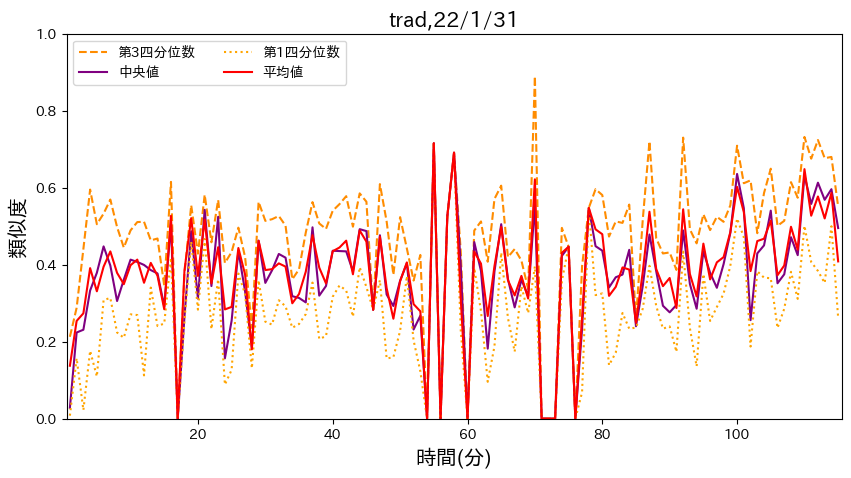

In [18]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "trad,22/1/31", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows+0.5)
    ax.set_ylim(0, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均値")
    ax.legend(loc="upper left",  ncol=2)
    plt.savefig('quantile.png')


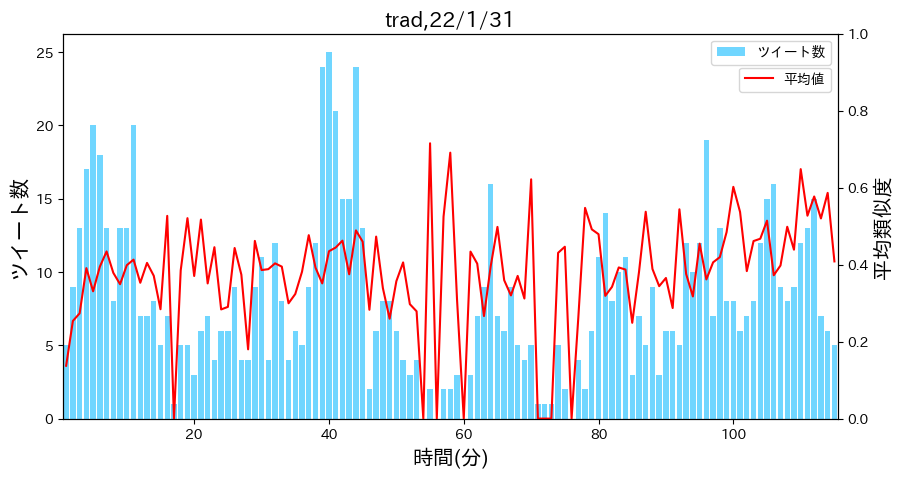

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "trad,22/1/31", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均類似度", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('mean.png')


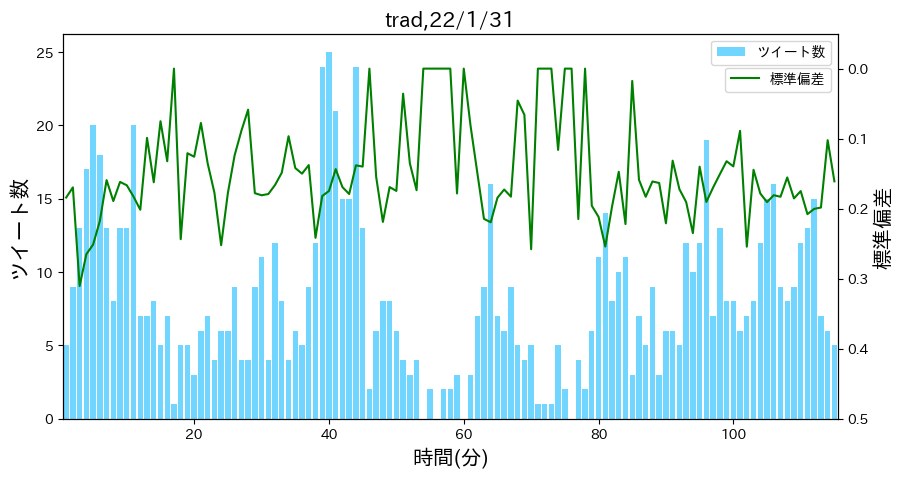

In [20]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "trad,22/1/31", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, -0.05)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('stdev.png')
